In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from vpython import *

In [16]:
%load_ext autoreload
%autoreload 2
import AV_CW

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
head =AV_CW.ThreeDHead.read_from_file(3,5)
head.filter_nan()
head.sparsify(0.3)
head.filter_depth(1.5)
head.center()

In [62]:
head.create_vpython_spheres()
head.save()

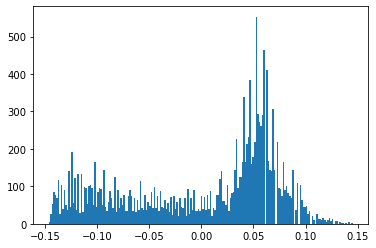

In [63]:
plt.hist(head.xyz[:,2], bins =200)
plt.show()

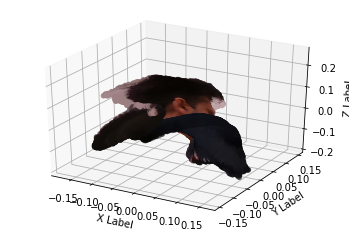

In [64]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(head.xyz[:,0], -head.xyz[:,2], -head.xyz[:,1], c=head.rgb)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
